<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
#  7RF1 DJ Sweep: g, gamma_phi, Q=g/gamma, kappa=g^2/gamma
#  WOW REGIME, Nature-style (nearest interpolation)
# ============================================================

# --- 0) Install gemmi (for CIF handling) --------------------  # [001]
!pip install -q gemmi                                        # [002]

# --- 1) Mount Google Drive ---------------------------------  # [010]
from google.colab import drive                               # [011]
drive.mount("/content/drive")                                # [012]

# --- 2) Imports --------------------------------------------- # [020]
import math                                                  # [021]
import shutil                                                # [022]
from pathlib import Path                                     # [023]

import numpy as np                                           # [024]
import matplotlib.pyplot as plt                              # [025]
from scipy.linalg import expm                                # [026]
from scipy.optimize import curve_fit                         # [027]
from scipy.signal import hilbert                             # [028]

import gemmi                                                 # [029]

# --- 3) Global constants (WOW regime physics) --------------- # [040]
H_BAR        = 6.582119569e-16       # eV·s                   # [041]
H_BAR_EV_FS  = 6.582119569e-1        # eV·fs (≈0.6582)        # [042]
DT_FS        = 0.02                  # fs                     # [043]
DT_S         = DT_FS * 1e-15         # seconds                # [044]
TOTAL_FS     = 40.0                  # fs                     # [045]
N_STEPS      = int(TOTAL_FS / DT_FS)                         # [046]

T0           = 10.0                  # strong coupling        # [047]
BETA_E       = 1.0                   # base decay 1/Å         # [048]
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]                     # [049]
COMB_WIDTH   = 0.18                                             # [050]

# --- 4) Paths and structure --------------------------------- # [060]
CONTENT_ROOT = Path("/content")                               # [061]
DRIVE_ROOT   = Path("/content/drive/MyDrive")                 # [062]

CIF_DIR      = DRIVE_ROOT / "psii_cifs"                       # [063]
OUT_DIR_CT   = CONTENT_ROOT / "dj_maps_7RF1"                  # [064]
OUT_DIR_DR   = DRIVE_ROOT / "dj_maps_7RF1"                    # [065]

CIF_DIR.mkdir(parents=True, exist_ok=True)                    # [066]
OUT_DIR_CT.mkdir(parents=True, exist_ok=True)                 # [067]
OUT_DIR_DR.mkdir(parents=True, exist_ok=True)                 # [068]

STRUCTURE = "7RF1"                                            # [069]

# High-res DJ grid                                             # [080]
duties = np.linspace(0.70, 1.00, 200)   # duty cycle          # [081]
betas  = np.linspace(0.80, 1.20, 200)   # beta_water/beta     # [082]

STAMP_TEXT = (                                                 # [083]
    f"7RF1, DT={DT_FS:.3f} fs, T={TOTAL_FS:.1f} fs, "          # [084]
    f"N={N_STEPS}, grid={len(duties)}×{len(betas)}, "          # [085]
    "interp=nearest"                                           # [086]
)                                                              # [087]

# --- 5) Geometry helpers ------------------------------------ # [090]
def _atom_iter(struct):                                       # [091]
    for model in struct:                                      # [092]
        for chain in model:                                   # [093]
            for res in chain:                                 # [094]
                for atom in res:                              # [095]
                    yield model, chain, res, atom             # [096]

def _combinations(iterable, r):                               # [100]
    pool = tuple(iterable)                                   # [101]
    n = len(pool)                                            # [102]
    if r > n:                                                # [103]
        return                                               # [104]
    idx = list(range(r))                                     # [105]
    yield tuple(pool[i] for i in idx)                        # [106]
    while True:                                              # [107]
        for i in reversed(range(r)):                         # [108]
            if idx[i] != i + n - r:                          # [109]
                break                                        # [110]
        else:                                                # [111]
            return                                           # [112]
        idx[i] += 1                                          # [113]
        for j in range(i + 1, r):                            # [114]
            idx[j] = idx[j - 1] + 1                          # [115]
        yield tuple(pool[i] for i in idx)                    # [116]

def read_structure_any(path):                                # [120]
    st = gemmi.read_structure(str(path))                     # [121]
    st.remove_alternative_conformations()                    # [122]
    st.merge_chain_parts()                                   # [123]
    st.remove_empty_chains()                                 # [124]
    return st                                                # [125]

def get_psii_core_16(struct):                                # [130]
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []  # [131]

    for _, _, res, atom in _atom_iter(struct):               # [132]
        el   = atom.element.name.upper()                     # [133]
        resn = res.name.upper()                              # [134]
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z],
                        dtype=float)                         # [135]
        if el == "MN":                                       # [136]
            mn_atoms.append((pos, res, atom))                # [137]
        elif el == "CA":                                     # [138]
            ca_atoms.append((pos, res, atom))                # [139]
        elif el == "O":                                      # [140]
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):  # [141]
                water_oxy.append((pos, res, atom))           # [142]
            else:                                            # [143]
                oxy_atoms.append((pos, res, atom))           # [144]

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:              # [150]
        raise RuntimeError("Not enough Mn/Ca atoms")         # [151]

    mn_positions = np.array([p for (p, _, _) in mn_atoms])   # [152]
    best_idx = None                                          # [153]
    best_score = 1e9                                         # [154]
    for idxs in _combinations(range(len(mn_positions)), 4):  # [155]
        pts   = mn_positions[list(idxs)]                     # [156]
        c     = pts.mean(axis=0)                             # [157]
        score = np.sum(np.linalg.norm(pts - c, axis=1))      # [158]
        if score < best_score:                               # [159]
            best_score = score                               # [160]
            best_idx   = idxs                                # [161]

    Mn_sel = [mn_atoms[i] for i in best_idx]                 # [165]
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])           # [166]

    c_mn   = Mn_pos.mean(axis=0)                             # [170]
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))  # [171]
    Ca_pos = Ca_sel[0]                                       # [172]

    # μ-oxo: O within 2.4 Å of two Mn                         # [180]
    mu_oxo = []                                              # [181]
    for (pos, res, atom) in oxy_atoms:                       # [182]
        d = np.linalg.norm(Mn_pos - pos, axis=1)             # [183]
        close_mn = np.where(d < 2.4)[0]                      # [184]
        if len(close_mn) >= 2:                               # [185]
            mu_oxo.append((pos, res, atom))                  # [186]
    if len(mu_oxo) < 5:                                      # [187]
        raise RuntimeError("Not enough μ-oxo candidates")    # [188]
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))   # [189]
    OX_sel = mu_oxo[:5]                                      # [190]
    OX_pos = np.array([p for (p, _, _) in OX_sel])           # [191]

    # Waters: nearest 2 to Mn4Ca centroid                     # [200]
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)  # [201]
    if len(water_oxy) < 2:                                   # [202]
        raise RuntimeError("Not enough waters")              # [203]
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))  # [204]
    W_sel = water_oxy[:2]                                    # [205]
    W_pos = np.array([p for (p, _, _) in W_sel])             # [206]

    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])  # [210]
    extra_needed = 16 - coords.shape[0]                      # [211]
    extras = []                                              # [212]
    others = water_oxy[2:] if len(water_oxy) > 2 else []     # [213]
    for i in range(extra_needed):                            # [214]
        if i < len(others):                                  # [215]
            extras.append(others[i][0])                      # [216]
        else:                                                # [217]
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))  # [218]
    if extras:                                               # [219]
        coords = np.vstack([coords, np.array(extras)])       # [220]

    if coords.shape[0] != 16:                                # [221]
        raise RuntimeError("Core is not 16 sites")           # [222]

    labels = (                                               # [230]
        [f"Mn{i+1}" for i in range(4)] +                     # [231]
        ["Ca"] +                                             # [232]
        [f"muO{i+1}" for i in range(5)] +                    # [233]
        ["OW3", "OW4"] +                                     # [234]
        [f"OWx{i+1}" for i in range(extra_needed)]           # [235]
    )
    return coords, labels                                    # [236]

# --- 6) Hamiltonian + TDSE + g, gamma extraction ------------# [240]
def resonance_comb(r):                                       # [241]
    val = 0.0                                                # [242]
    for c in COMB_CENTERS:                                   # [243]
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))  # [244]
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))    # [245]

def build_hamiltonian(coords, duty, beta_scale_water):       # [250]
    coords = np.asarray(coords, float)                       # [251]
    n = coords.shape[0]                                      # [252]
    H = np.zeros((n, n), dtype=np.complex128)                # [253]

    diag = np.array([                                        # [254]
        2.0, 2.0, 2.0, 2.0,      # Mn                         # [255]
        0.7,                     # Ca                         # [256]
        1.0, 1.0, 1.0, 1.0, 1.0, # mu-oxo                    # [257]
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2  # waters               # [258]
    ], dtype=float)                                          # [259]
    np.fill_diagonal(H, diag)                                # [260]

    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)  # [261]
    for i in range(n):                                       # [262]
        for j in range(i + 1, n):                            # [263]
            r = R[i, j]                                      # [264]
            beta = BETA_E                                    # [265]
            if (i >= 10) or (j >= 10):                       # [266]
                beta = BETA_E * beta_scale_water             # [267]
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty  # [268]
            H[i, j] = H[j, i] = Tij                          # [269]

    return H                                                 # [270]

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):    # [280]
    t = np.asarray(t_fs)                                     # [281]
    P1 = np.asarray(P1)                                      # [282]
    P2 = np.asarray(P2)                                      # [283]
    if t_max is None:                                        # [284]
        t_max = t[int(0.5 * len(t))]                         # [285]
    if len(t) < 3:                                           # [286]
        return np.nan, np.nan                                # [287]

    dP = (P1 - P2)                                           # [288]
    dP = dP - dP.mean()                                      # [289]

    dt = float(t[1] - t[0])                                  # [290]
    freqs = np.fft.rfftfreq(len(t), dt)                      # [291]
    spec  = np.abs(np.fft.rfft(dP)) ** 2                     # [292]
    if len(freqs) < 2:                                       # [293]
        return np.nan, np.nan                                # [294]

    peak_idx = np.argmax(spec[1:]) + 1                       # [295]
    Omega    = 2.0 * np.pi * freqs[peak_idx]                 # [296]
    g        = H_BAR_EV_FS * Omega                           # [297]

    analytic = hilbert(dP)                                   # [298]
    env      = np.abs(analytic)                              # [299]

    mask    = (t >= t_min) & (t <= t_max)                    # [300]
    t_fit   = t[mask]                                        # [301]
    env_fit = env[mask]                                      # [302]
    if len(t_fit) < 5:                                       # [303]
        return g, np.nan                                     # [304]

    def model(tt, A, gamma, C):                              # [305]
        return A * np.exp(-gamma * tt) + C                   # [306]

    try:                                                     # [307]
        A0 = env_fit.max() - env_fit.min()                   # [308]
        C0 = env_fit.min()                                   # [309]
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)             # [310]
        popt, _ = curve_fit(model, t_fit, env_fit,           # [311]
                            p0=[A0, g0, C0], maxfev=10000)   # [312]
        gamma_phi = abs(float(popt[1]))                      # [313]
    except Exception:                                        # [314]
        gamma_phi = np.nan                                   # [315]

    return g, gamma_phi                                      # [316]

def run_tdse_camn(coords, labels, duty, beta_scale_water):   # [320]
    H = build_hamiltonian(coords, duty, beta_scale_water)    # [321]
    n = coords.shape[0]                                      # [322]
    psi = np.zeros(n, dtype=np.complex128)                   # [323]
    psi[0] = 1.0                                             # [324]

    t_axis_fs = np.arange(N_STEPS) * DT_FS                   # [325]

    try:                                                     # [326]
        idx_Ca = labels.index("Ca")                          # [327]
        idx_Mn = labels.index("Mn3")                         # [328]
    except ValueError:                                       # [329]
        raise RuntimeError("Missing Ca/Mn3 labels")          # [330]

    P_Ca = np.zeros(N_STEPS, dtype=float)                    # [331]
    P_Mn = np.zeros(N_STEPS, dtype=float)                    # [332]

    U = expm(-1j * H * (DT_S / H_BAR))                       # [333]

    for k in range(N_STEPS):                                 # [334]
        p = np.abs(psi) ** 2                                 # [335]
        P_Ca[k] = p[idx_Ca]                                  # [336]
        P_Mn[k] = p[idx_Mn]                                  # [337]
        psi = U @ psi                                        # [338]
        psi /= np.linalg.norm(psi)                           # [339]

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,    # [340]
                                   t_min=0.0,                # [341]
                                   t_max=min(20.0, float(t_axis_fs[-1])))  # [342]
    return g, gamma_phi                                      # [343]

# --- 7) Load 7RF1 CIF and mirror to Drive if needed ---------# [350]
cif_name   = f"{STRUCTURE}.cif"                              # [351]
cif_path_ct = CONTENT_ROOT / cif_name                        # [352]
cif_path_dr = CIF_DIR / cif_name                             # [353]

if cif_path_ct.exists():                                     # [354]
    cif_path = cif_path_ct                                   # [355]
    if not cif_path_dr.exists():                             # [356]
        shutil.copy2(cif_path_ct, cif_path_dr)               # [357]
elif cif_path_dr.exists():                                   # [358]
    cif_path = cif_path_dr                                   # [359]
else:                                                        # [360]
    raise FileNotFoundError(
        f"7RF1 CIF not found in /content or {CIF_DIR}. Upload it first."
    )                                                        # [361]

print(f"Using 7RF1 CIF from: {cif_path}")                    # [362]
st = read_structure_any(cif_path)                            # [363]
coords, labels = get_psii_core_16(st)                        # [364]

# --- 8) Allocate grids for g, gamma, Q, kappa -------------- # [370]
n_d = len(duties)                                            # [371]
n_b = len(betas)                                             # [372]

g_grid      = np.zeros((n_d, n_b))                           # [373]
gamma_grid  = np.zeros((n_d, n_b))                           # [374]
Q_grid      = np.zeros((n_d, n_b))                           # [375]
kappa_grid  = np.zeros((n_d, n_b))                           # [376]

# --- 9) Main sweep over (duty, beta) ------------------------# [380]
for i, duty in enumerate(duties):                            # [381]
    print(f"Row {i+1}/{n_d} (duty={duty:.3f}) ...")          # [382]
    for j, beta_scale in enumerate(betas):                   # [383]
        g_val, gamma_val = run_tdse_camn(coords, labels,     # [384]
                                         duty, beta_scale)   # [385]
        g_grid[i, j]     = g_val                             # [386]
        gamma_grid[i, j] = gamma_val                         # [387]

        if np.isfinite(g_val) and (gamma_val is not None) and (gamma_val > 0):  # [388]
            Q_grid[i, j]     = g_val / gamma_val             # [389]
            kappa_grid[i, j] = (g_val ** 2) / gamma_val      # [390]
        else:                                                # [391]
            Q_grid[i, j]     = np.nan                        # [392]
            kappa_grid[i, j] = np.nan                        # [393]

print("Sweep complete.")                                     # [394]

# --- 10) Save master NPZ (content + drive) ------------------# [400]
master_npz_ct = OUT_DIR_CT / "DJ_7RF1_g_gamma_Q_kappa_wow.npz"  # [401]
np.savez(master_npz_ct,
         duties=duties, betas=betas,
         g_grid=g_grid,
         gamma_grid=gamma_grid,
         Q_grid=Q_grid,
         kappa_grid=kappa_grid)                              # [402]

master_npz_dr = OUT_DIR_DR / master_npz_ct.name              # [403]
shutil.copy2(master_npz_ct, master_npz_dr)                   # [404]

print("Saved master NPZ to:")                                # [405]
print("  Content:", master_npz_ct)                           # [406]
print("  Drive  :", master_npz_dr)                           # [407]

# --- 11) Plot helper for a single map -----------------------# [410]
def plot_map(z_grid, title, fname_stub, cmap="viridis",      # [411]
             vmin=None, vmax=None):                          # [412]
    fig, ax = plt.subplots(figsize=(6, 4.8))                 # [413]
    extent = [betas[0], betas[-1], duties[0], duties[-1]]    # [414]
    im = ax.imshow(z_grid, origin="lower", extent=extent,    # [415]
                   aspect="auto", interpolation="nearest",   # [416]
                   vmin=vmin, vmax=vmax, cmap=cmap)          # [417]
    ax.set_title(title)                                      # [418]
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")         # [419]
    ax.set_ylabel("Duty cycle")                              # [420]

    ax.text(0.01, 0.02, STAMP_TEXT,                          # [421]
            transform=ax.transAxes,                          # [422]
            fontsize=7, color="white",                       # [423]
            ha="left", va="bottom",                          # [424]
            bbox=dict(facecolor="black", alpha=0.5, pad=2))  # [425]

    cbar = fig.colorbar(im)                                  # [426]
    cbar.set_label(title)                                    # [427]

    png_path_ct = OUT_DIR_CT / f"{fname_stub}.png"           # [428]
    pdf_path_ct = OUT_DIR_CT / f"{fname_stub}.pdf"           # [429]
    fig.savefig(png_path_ct, dpi=600)                        # [430]
    fig.savefig(pdf_path_ct)                                 # [431]

    shutil.copy2(png_path_ct, OUT_DIR_DR / png_path_ct.name) # [432]
    shutil.copy2(pdf_path_ct, OUT_DIR_DR / pdf_path_ct.name) # [433]

    plt.show()                                               # [434]
    plt.close(fig)                                           # [435]

    print(f"Saved {title} maps to:")                         # [436]
    print("  ", png_path_ct)                                 # [437]
    print("  ", pdf_path_ct)                                 # [438]

# --- 12) Individual maps: g, gamma, Q, kappa ----------------# [450]
# g map
g_min = np.nanmin(g_grid)                                   # [451]
g_max = np.nanmax(g_grid)                                   # [452]
plot_map(g_grid,
         title=r"$g$ (eV)",                                 # [453]
         fname_stub="DJ_7RF1_g_wow",                        # [454]
         vmin=g_min, vmax=g_max)                            # [455]

# gamma map
gamma_pos = gamma_grid[gamma_grid > 0]                      # [456]
if gamma_pos.size > 0:                                      # [457]
    gm_min = np.nanmin(gamma_pos)                           # [458]
    gm_max = np.nanmax(gamma_pos)                           # [459]
else:                                                       # [460]
    gm_min, gm_max = np.nanmin(gamma_grid), np.nanmax(gamma_grid)  # [461]

plot_map(gamma_grid,
         title=r"$\gamma_{\phi}$ (fs$^{-1}$)",              # [462]
         fname_stub="DJ_7RF1_gamma_wow",                    # [463]
         vmin=gm_min, vmax=gm_max)                          # [464]

# Q map (g/gamma) – may have large dynamic range
Q_valid = Q_grid[np.isfinite(Q_grid)]                       # [465]
if Q_valid.size > 0:                                        # [466]
    Q_min = np.nanpercentile(Q_valid, 1.0)                  # [467]
    Q_max = np.nanpercentile(Q_valid, 99.0)                 # [468]
else:                                                       # [469]
    Q_min, Q_max = np.nanmin(Q_grid), np.nanmax(Q_grid)     # [470]

plot_map(Q_grid,
         title=r"$Q = g/\gamma_{\phi}$",                    # [471]
         fname_stub="DJ_7RF1_Q_wow",                        # [472]
         vmin=Q_min, vmax=Q_max)                            # [473]

# kappa map (Shield curvature)
k_valid = kappa_grid[np.isfinite(kappa_grid)]               # [474]
if k_valid.size > 0:                                        # [475]
    k_min = np.nanpercentile(k_valid, 1.0)                  # [476]
    k_max = np.nanpercentile(k_valid, 99.0)                 # [477]
else:                                                       # [478]
    k_min, k_max = np.nanmin(kappa_grid), np.nanmax(kappa_grid)  # [479]

plot_map(kappa_grid,
         title=r"$\kappa = g^2/\gamma_{\phi}$",             # [480]
         fname_stub="DJ_7RF1_kappa_wow",                    # [481]
         vmin=k_min, vmax=k_max)                            # [482]

# --- 13) 2×2 composite (g, gamma, Q, kappa) -----------------# [490]
fig, axes = plt.subplots(2, 2, figsize=(12, 9),             # [491]
                         sharex=True, sharey=True)          # [492]
extent = [betas[0], betas[-1], duties[0], duties[-1]]       # [493]

panel_data = [                                               # [494]
    (g_grid,      r"$g$ (eV)",                   (g_min, g_max)),
    (gamma_grid,  r"$\gamma_{\phi}$ (fs$^{-1}$)", (gm_min, gm_max)),
    (Q_grid,      r"$Q = g/\gamma_{\phi}$",      (Q_min, Q_max)),
    (kappa_grid,  r"$\kappa = g^2/\gamma_{\phi}$", (k_min, k_max)),
]                                                            # [495]

for ax, (data, title, (vmin, vmax)) in zip(axes.ravel(), panel_data):  # [496]
    im = ax.imshow(data, origin="lower", extent=extent,      # [497]
                   aspect="auto", interpolation="nearest",   # [498]
                   vmin=vmin, vmax=vmax)                     # [499]
    ax.set_title(title)                                      # [500]
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")         # [501]
    ax.set_ylabel("Duty cycle")                              # [502]
    ax.text(0.01, 0.02, STAMP_TEXT,                          # [503]
            transform=ax.transAxes,                          # [504]
            fontsize=6, color="white",                       # [505]
            ha="left", va="bottom",                          # [506]
            bbox=dict(facecolor="black", alpha=0.5, pad=1))  # [507]

fig.suptitle(r"7RF1 DJ sweep: $g$, $\gamma_{\phi}$, "
             r"$Q$, $\kappa$ (H$_2$O, WOW regime)",          # [508]
             fontsize=14)                                    # [509]

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                    # [510]

comp_png_ct = OUT_DIR_CT / "DJ_7RF1_composite_g_gamma_Q_kappa.png"  # [511]
comp_pdf_ct = OUT_DIR_CT / "DJ_7RF1_composite_g_gamma_Q_kappa.pdf"  # [512]
fig.savefig(comp_png_ct, dpi=600)                            # [513]
fig.savefig(comp_pdf_ct)                                     # [514]

shutil.copy2(comp_png_ct, OUT_DIR_DR / comp_png_ct.name)     # [515]
shutil.copy2(comp_pdf_ct, OUT_DIR_DR / comp_pdf_ct.name)     # [516]

plt.show()                                                   # [517]
plt.close(fig)                                               # [518]

print("\nComposite figure saved to:")                        # [519]
print("  ", comp_png_ct)                                     # [520]
print("  ", comp_pdf_ct)                                     # [521]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using 7RF1 CIF from: /content/7RF1.cif
Row 1/200 (duty=0.700) ...


KeyboardInterrupt: 

In [ ]:
# ================================================
# Zip the DJ maps folder (content + drive copies)
# ================================================
import shutil
from pathlib import Path

# Paths
OUT_DIR_CT = Path("/content/dj_maps_7RF1")
OUT_DIR_DR = Path("/content/drive/MyDrive/dj_maps_7RF1")

ZIP_CT = Path("/content/dj_maps_7RF1.zip")
ZIP_DR = Path("/content/drive/MyDrive/dj_maps_7RF1.zip")

# Zip the content directory
shutil.make_archive(
    base_name=str(ZIP_CT).replace(".zip",""),   # strip .zip for make_archive
    format="zip",
    root_dir=str(OUT_DIR_CT)
)

# Copy zip into Drive
shutil.copy2(ZIP_CT, ZIP_DR)

print("Created ZIP:")
print("  Content:", ZIP_CT)
print("  Drive  :", ZIP_DR)

Created ZIP:
  Content: /content/dj_maps_7RF1.zip
  Drive  : /content/drive/MyDrive/dj_maps_7RF1.zip


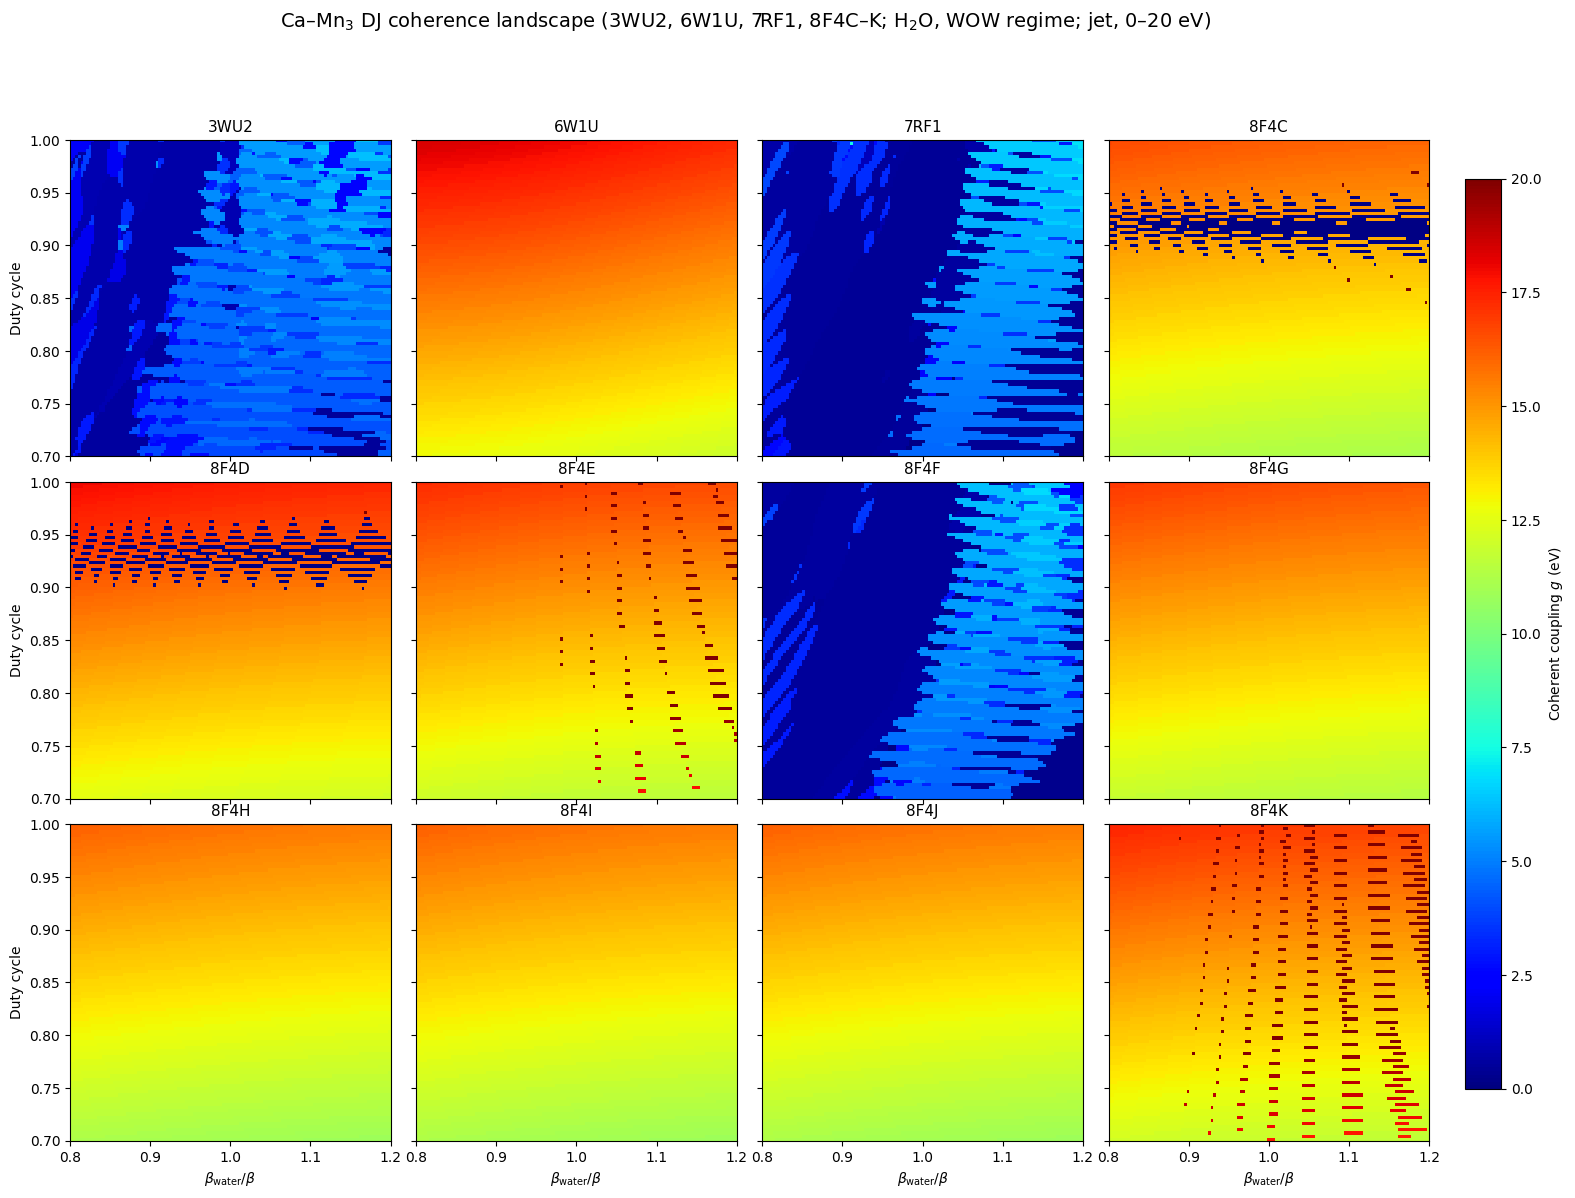

Saved:
  /content/DJ_3x4_wow_jet_0to20eV.png
  /content/DJ_3x4_wow_jet_0to20eV.pdf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- load master NPZ (already created by your sweep) ----
master_npz = "/content/DJ_all_structs_wow.npz"
data = np.load(master_npz, allow_pickle=True)

duties = data["duties"]
betas  = data["betas"]

STRUCTURES = [
    "3WU2", "6W1U", "7RF1",
    "8F4C", "8F4D", "8F4E",
    "8F4F", "8F4G", "8F4H",
    "8F4I", "8F4J", "8F4K",
]

g_grids = {s: data[s] for s in STRUCTURES}

# ---- plotting params ----
rows, cols = 3, 4
vmin, vmax = 0.0, 20.0           # fixed global scale
cmap_name  = "jet"               # as requested
extent = [betas[0], betas[-1], duties[0], duties[-1]]

fig, axes = plt.subplots(rows, cols, figsize=(18, 13),
                         sharex=True, sharey=True)
fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

for k, struct in enumerate(STRUCTURES):
    r = k // cols
    c = k %  cols
    ax = axes[r, c]
    g = g_grids[struct]

    im = ax.imshow(
        g,
        origin="lower",
        extent=extent,
        interpolation="nearest",
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        cmap=cmap_name,
    )

    ax.set_title(struct, fontsize=11)
    if r == rows - 1:
        ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
    if c == 0:
        ax.set_ylabel("Duty cycle")

# shared colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r"Coherent coupling $g$ (eV)")

fig.suptitle("Ca–Mn$_3$ DJ coherence landscape "
             "(3WU2, 6W1U, 7RF1, 8F4C–K; H$_2$O, WOW regime; jet, 0–20 eV)",
             fontsize=14)

out_png = Path("/content/DJ_3x4_wow_jet_0to20eV.png")
out_pdf = Path("/content/DJ_3x4_wow_jet_0to20eV.pdf")

out_png.parent.mkdir(parents=True, exist_ok=True)

fig.savefig(out_png, dpi=600)
fig.savefig(out_pdf)

plt.show()
print("Saved:")
print(" ", out_png)
print(" ", out_pdf)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------
# Load all the DJ_{s}_wow.npz files
# --------------------------------------------
base_dir = Path("/content/dj_maps")
STRUCTURES = [
    "8F4C","8F4D","8F4E",
    "8F4F","8F4G","8F4H",
    "8F4I","8F4J","8F4K",
]

g_all, gamma_all, Q_all, kappa_all = {}, {}, {}, {}
duties, betas = None, None

for s in STRUCTURES:
    dat = np.load(base_dir / f"DJ_{s}_wow.npz")
    if duties is None:
        duties = dat["duties"]
        betas  = dat["betas"]
    g_all[s]     = dat["g_grid"]
    gamma_all[s] = dat["gamma_grid"]
    Q_all[s]     = dat["Q_grid"]
    kappa_all[s] = dat["kappa_grid"]

extent = [betas[0], betas[-1], duties[0], duties[-1]]

# ---------------------------------------------------------
# MASKING — choose gamma threshold based on 20% percentile
# ---------------------------------------------------------
gamma_stack = np.stack([gamma_all[s] for s in STRUCTURES], axis=0)
gamma_valid = gamma_stack[np.isfinite(gamma_stack) & (gamma_stack > 0)]

GAMMA_MIN = float(np.nanpercentile(gamma_valid, 20.0))
print("Gamma threshold chosen =", GAMMA_MIN)

Q_masked, K_masked = {}, {}

for s in STRUCTURES:
    g, gamma, Q, K = g_all[s], gamma_all[s], Q_all[s], kappa_all[s]

    valid = (gamma > GAMMA_MIN) & np.isfinite(Q) & np.isfinite(K)
    Qm = np.full_like(Q, np.nan)
    Km = np.full_like(K, np.nan)
    Qm[valid] = Q[valid]
    Km[valid] = K[valid]
    Q_masked[s] = Qm
    K_masked[s] = Km

# ---------------------------------------------------------
# LOG10 Q and LOG10 K (masked)
# ---------------------------------------------------------
def composite_log(grid_dict, title, fname):
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    # gather values for scaling
    vals = np.hstack([grid_dict[s][np.isfinite(grid_dict[s])] for s in STRUCTURES])
    vmin, vmax = np.nanpercentile(vals, 5), np.nanpercentile(vals, 95)

    for k,s in enumerate(STRUCTURES):
        r, c = k//cols, k%cols
        ax = axes[r,c]
        grid = grid_dict[s]
        im = ax.imshow(np.log10(grid), origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=np.log10(vmin), vmax=np.log10(vmax), cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title + " (log10)")

    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing LOG10(Q_masked)")
composite_log(Q_masked, r"$Q = g/\gamma_{\varphi}$", "Composite_LOG_Q_masked")

print("\n>>> Drawing LOG10(K_masked)")
composite_log(K_masked, r"$\kappa = g^2/\gamma_{\varphi}$", "Composite_LOG_K_masked")

# ---------------------------------------------------------
# RATIO: kappa/Q = g  (sanity check)
# ---------------------------------------------------------
def composite_ratio(title, fname):
    fig, axes = plt.subplots(3, 3, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    for k,s in enumerate(STRUCTURES):
        r, c = k//3, k%3
        ax = axes[r,c]
        ratio = np.full_like(g_all[s], np.nan)
        mask = np.isfinite(Q_masked[s]) & np.isfinite(K_masked[s])
        ratio[mask] = K_masked[s][mask] / Q_masked[s][mask]  # = g

        gvals = ratio[np.isfinite(ratio)]
        vmin, vmax = np.nanpercentile(gvals, 5), np.nanpercentile(gvals, 95)

        im = ax.imshow(ratio, origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=vmin, vmax=vmax, cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title)
    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing RATIO κ/Q = g")
composite_ratio("κ/Q = g  (ratio check)", "Composite_ratio_K_over_Q")

# ---------------------------------------------------------
# Per-panel autoscale for Q and κ — reveals structural differences
# ---------------------------------------------------------
def composite_autoscale(grid_dict, title, fname):
    fig, axes = plt.subplots(3,3, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    for k,s in enumerate(STRUCTURES):
        r,c = k//3, k%3
        ax = axes[r,c]
        grid = grid_dict[s]
        vals = grid[np.isfinite(grid)]
        if vals.size==0:
            im=ax.imshow(grid, origin="lower", extent=extent); continue
        vmin, vmax = np.nanpercentile(vals, 5), np.nanpercentile(vals, 95)

        im = ax.imshow(grid, origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=vmin, vmax=vmax, cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title)
    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing AUTO-SCALE Q (masked)")
composite_autoscale(Q_masked, "Q masked (panel auto-scale)", "Composite_Q_masked_autoscale")

print("\n>>> Drawing AUTO-SCALE κ (masked)")
composite_autoscale(K_masked, "κ masked (panel auto-scale)", "Composite_K_masked_autoscale")

FileNotFoundError: [Errno 2] No such file or directory: '/content/dj_maps/DJ_8F4C_wow.npz'